In [1]:
!pip install -qqq easy-vqa
!pip install -qqq sentence_transformers transformers timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.4 MB/s eta 0:00:00


In [2]:
from easy_vqa import get_train_questions, get_test_questions

train_questions, train_answers, train_image_ids = get_train_questions()
test_questions, test_answers, test_image_ids = get_test_questions()

In [3]:
from easy_vqa import get_train_questions, get_test_questions
from easy_vqa import get_train_image_paths, get_test_image_paths
from matplotlib import pyplot as plt
train_image_paths = get_train_image_paths()
test_image_paths = get_test_image_paths()

print(train_image_paths[1])

/usr/local/lib/python3.10/dist-packages/easy_vqa/data/train/images/1.png


In [4]:
import pandas as pd
pd.set_option("max_colwidth", None)

def gen_dataframes(questions, answers, image_ids, mode="train"):
    records = []
    for question, answer, image_id in zip(questions, answers, image_ids):
        image_path = f"/usr/local/lib/python3.10/dist-packages/easy_vqa/data/{mode}/images/{image_id}.png"
        records.append({"question" : question, "answer": answer, "image_path": image_path})
    return pd.DataFrame(records)

df =  gen_dataframes(train_questions, train_answers, train_image_ids)
from sklearn.model_selection import train_test_split
df = df.sample(frac=1)
train_df, eval_df = train_test_split(df)
test_df =  gen_dataframes(test_questions, test_answers, test_image_ids, mode="test")

In [5]:
print(train_df.shape)
print(eval_df.shape)
print(test_df.shape)

(28931, 3)
(9644, 3)
(9673, 3)


In [6]:
from easy_vqa import get_answers

answers = get_answers()
print("Total labels", len(answers))
label2idx = {answer:i for i, answer in enumerate(answers)}

Total labels 13


In [7]:
label2idx

{'circle': 0,
 'green': 1,
 'red': 2,
 'gray': 3,
 'yes': 4,
 'teal': 5,
 'black': 6,
 'rectangle': 7,
 'yellow': 8,
 'triangle': 9,
 'brown': 10,
 'blue': 11,
 'no': 12}

In [8]:
train_df["label"] = train_df["answer"].apply(lambda x: label2idx.get(x))
eval_df["label"] = eval_df["answer"].apply(lambda x: label2idx.get(x))
test_df["label"] = test_df["answer"].apply(lambda x: label2idx.get(x))

In [9]:
train_df.sample(5)

,question,answer,image_path,label
15550,is no yellow shape present?,yes,/usr/local/lib/python3.10/dist-packages/easy_vqa/data/train/images/1616.png,4
33175,is there a green shape in the image?,no,/usr/local/lib/python3.10/dist-packages/easy_vqa/data/train/images/3445.png,12
7321,is there not a rectangle?,no,/usr/local/lib/python3.10/dist-packages/easy_vqa/data/train/images/753.png,12
13940,what shape is present?,triangle,/usr/local/lib/python3.10/dist-packages/easy_vqa/data/train/images/1449.png,9
814,what shape is in the image?,rectangle,/usr/local/lib/python3.10/dist-packages/easy_vqa/data/train/images/82.png,7


In [10]:
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel
import torchvision.transforms as T
import torch
import timm


""" Fusing Transformers """
device = "cuda:0" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = AutoModel.from_pretrained("bert-base-uncased")
for p in text_encoder.parameters():
    p.requires_grad = False


#image_processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
#image_encoder = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

""" Fusing CNNs and Transformers """
device = "cuda:0" if torch.cuda.is_available() else "cpu"
image_encoder = timm.create_model("resnet50d", pretrained=True,  num_classes=0)
resize_transform = T.Resize((224, 224))

for p in image_encoder.parameters():
    p.requires_grad = False


image_encoder.to(device)
text_encoder.to(device)

print()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [11]:
from PIL import Image
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

class EasyQADataset(Dataset):

    def __init__(self,df,
                 image_encoder,
                 text_encoder,
                 image_processor,
                 tokenizer,
              ):
        self.df = df
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.image_processor = image_processor
        self.tokenizer = tokenizer


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image_file = self.df["image_path"][idx]
        question = self.df['question'][idx]
        image = Image.open(image_file).convert("RGB")
        label = self.df['label'][idx]

        """ When CNNs are used for V backbone"""

        image = resize_transform(image)
        image_inputs = T.ToTensor()(image).unsqueeze_(0)
        image_inputs = image_inputs.to(device)
        image_outputs = self.image_encoder(image_inputs)
        image_embedding = image_outputs[0]
        image_embedding = image_embedding.detach()
        #print("Image emb", image_embedding.shape)


        text_inputs = self.tokenizer(question, return_tensors="pt")
        text_inputs = {k:v.to(device) for k,v in text_inputs.items()}
        text_outputs = self.text_encoder(**text_inputs)
        text_embedding = text_outputs.pooler_output # You can experiment with this or raw CLS embedding below
        #text_embedding = text_outputs.last_hidden_state[:,0,:] # Raw CLS embedding
        text_embedding = text_embedding.view(-1)
        text_embedding = text_embedding.detach()
        # print("Text emb", text_embedding.shape)

        encoding={}
        encoding["image_emb"] = image_embedding
        encoding["text_emb"] = text_embedding
        encoding["label"] = torch.tensor(label)

        return encoding

In [12]:
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

train_dataset = EasyQADataset(
                           df=train_df,
                           image_encoder = image_encoder,
                           text_encoder = text_encoder,
                           tokenizer = tokenizer,
                           image_processor = None, # Pass None when using CNNs
                           )

eval_dataset = EasyQADataset(
                           df=eval_df,
                           image_encoder = image_encoder,
                           text_encoder = text_encoder,
                           tokenizer = tokenizer,
                           image_processor = None,# Pass None when using CNNs
                          )

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
eval_batch_size = 32
dataloader_train = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)
dataloader_validation = DataLoader(eval_dataset,
                                   sampler=SequentialSampler(eval_dataset),
                                   batch_size=eval_batch_size)

In [35]:

from sklearn.metrics import accuracy_score

def accuracy_score_func(preds, labels):
    return accuracy_score(labels, preds)

In [26]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals, confidence = [], [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)

        inputs = {'image_emb':  batch[0], 'text_emb': batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)

        labels =  batch[2]
        loss = criterion(outputs.view(-1, 13), labels.view(-1))
        loss_val_total += loss.item()

        probs = torch.max(outputs.softmax(dim=1), dim=-1)[0].detach().cpu().numpy()
        outputs = outputs.argmax(-1)
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        confidence.append(probs)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    confidence = np.concatenate(confidence, axis=0)

    return loss_val_avg, predictions, true_vals, confidence

def accuracy_score_func(preds, labels):
    return np.mean(preds == labels)

def train():
    train_history = open("/content/models/train_history.csv", "w")
    log_hdr = "Epoch, train_loss, train_acc, val_loss, val_acc"
    train_history.write(log_hdr  + "\n")
    train_f1s = []
    val_f1s = []
    train_losses = []
    val_losses = []
    min_val_loss = -1
    max_auc_score = 0
    epochs_no_improve = 0
    early_stopping_epoch = 3
    early_stop = False

    epochs = 10  # Define the number of epochs
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        loss_train_total = 0
        train_predictions, train_true_vals = [], []

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)

            inputs = {'image_emb':  batch[0], 'text_emb': batch[1]}
            labels =  batch[2]

            # Check shapes of the embeddings
            assert inputs['image_emb'].shape[1] == 2048, "image_emb shape mismatch"
            assert inputs['text_emb'].shape[1] == 512, "text_emb shape mismatch"

            outputs = model(**inputs)
            loss = criterion(outputs.view(-1, 13), labels.view(-1))
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            logits = outputs.argmax(-1)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.cpu().numpy()
            train_predictions.append(logits)
            train_true_vals.append(label_ids)

            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        train_predictions = np.concatenate(train_predictions, axis=0)
        train_true_vals = np.concatenate(train_true_vals, axis=0)

        tqdm.write(f'\nEpoch {epoch}')
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
        train_f1 = accuracy_score_func(train_predictions, train_true_vals)
        tqdm.write(f'Train Acc: {train_f1}')

        val_loss, predictions, true_vals, _ = evaluate(dataloader_validation)
        val_f1 = accuracy_score_func(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'Val Acc: {val_f1}')

        if val_f1 >= max_auc_score:
            tqdm.write('\nSaving best model')
            torch.save(model.state_dict(), f'/content/models/easyvqa_finetuned_epoch_{epoch}.model')
            max_auc_score = val_f1

        train_losses.append(loss_train_avg)
        val_losses.append(val_loss)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        log_str = "{}, {}, {}, {}, {}".format(epoch, loss_train_avg, train_f1, val_loss, val_f1)
        train_history.write(log_str + "\n")

        if min_val_loss < 0:
            min_val_loss = val_loss
        else:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_epoch:
                    early_stop = True
                    break
                else:
                    continue

    if early_stop:
        print("Early Stopping activated at epoch -", epoch)
        print("Use the checkpoint at epoch - ", epoch - early_stopping_epoch)

    train_history.close()
    return train_losses, val_losses


In [27]:
import random
from torch import nn
from tqdm.notebook import tqdm
import numpy as np
import torch
import math
import requests
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

class EasyQAEarlyFusionNetwork(nn.Module):
    def __init__(self, hyperparms=None):
        super(EasyQAEarlyFusionNetwork, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.vision_projection = nn.Linear(2048, 768)
        self.text_projection = nn.Linear(512, 768)
        self.fc1 = nn.Linear(768, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.classifier = nn.Linear(256, 13)
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, image_emb, text_emb):
        x1 = torch.nn.functional.normalize(image_emb, p=2, dim=1)
        Xv = self.relu_f(self.vision_projection(x1))

        x2 = torch.nn.functional.normalize(text_emb, p=2, dim=1)
        Xt = self.relu_f(self.text_projection(x2))

        Xvt = Xv * Xt

        Xvt = torch.matmul(Xvt, self.W.t())
        Xvt = self.relu_f(Xvt)
        Xvt = torch.matmul(Xvt, self.W.t())
        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

In [28]:
import torch
import torch.nn as nn
import math
torch.cuda.empty_cache()
model =EasyQAEarlyFusionNetwork()
model.to(device)

EasyQAEarlyFusionNetwork(
  (dropout): Dropout(p=0.3, inplace=False)
  (vision_projection): Linear(in_features=2048, out_features=768, bias=True)
  (text_projection): Linear(in_features=512, out_features=768, bias=True)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=256, out_features=13, bias=True)
  (relu_f): ReLU()
)

In [29]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  weight_decay = 1e-5,
                  eps=1e-8
                  )

epochs = 10
train_steps=20000
print("train_steps", train_steps)
warm_steps = train_steps * 0.1
print("warm_steps", warm_steps)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warm_steps,
                                            num_training_steps=train_steps)

train_steps 20000
warm_steps 2000.0


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.570687234401703
Train Acc: 0.09
Validation loss: 2.5711922645568848
Val Acc: 0.05

Saving best model


Epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2
Training loss: 2.5668424367904663
Train Acc: 0.09
Validation loss: 2.570526123046875
Val Acc: 0.05

Saving best model


Epoch 3:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3
Training loss: 2.559713363647461
Train Acc: 0.08
Validation loss: 2.569990336894989
Val Acc: 0.05

Saving best model


Epoch 4:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 4
Training loss: 2.5679598450660706
Train Acc: 0.08
Validation loss: 2.56955885887146
Val Acc: 0.09

Saving best model


Epoch 5:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5
Training loss: 2.5664068460464478
Train Acc: 0.08
Validation loss: 2.569211184978485
Val Acc: 0.09

Saving best model


Epoch 6:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 6
Training loss: 2.560421884059906
Train Acc: 0.08
Validation loss: 2.568930685520172
Val Acc: 0.09

Saving best model


Epoch 7:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 7
Training loss: 2.5716007947921753
Train Acc: 0.08
Validation loss: 2.568702220916748
Val Acc: 0.09

Saving best model


Epoch 8:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 8
Training loss: 2.5688536167144775
Train Acc: 0.07
Validation loss: 2.5685174465179443
Val Acc: 0.09

Saving best model


Epoch 9:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 9
Training loss: 2.565723419189453
Train Acc: 0.08
Validation loss: 2.568366765975952
Val Acc: 0.09

Saving best model


Epoch 10:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10
Training loss: 2.5673038959503174
Train Acc: 0.08
Validation loss: 2.568243145942688
Val Acc: 0.09

Saving best model


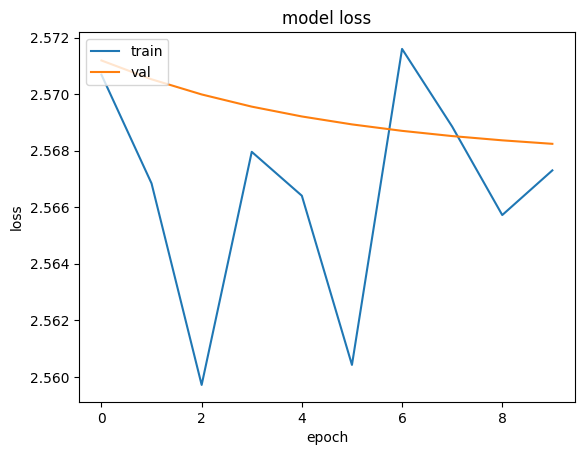

In [30]:
from matplotlib import pyplot as plt
try:
  !rm -rf /content/models
  !mkdir /content/models
  train_losses, val_losses =  train()
  torch.cuda.empty_cache()
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
except Exception as e:
    print(f"An error occurred: {e}")

In [32]:
test_dataset = EasyQADataset(
                           df=test_df,
                           image_encoder = image_encoder,
                           text_encoder = text_encoder,
                           tokenizer = tokenizer,
                           image_processor = None
                           )

In [33]:
device = "cuda:0"
model.load_state_dict(torch.load('/content/models/easyvqa_finetuned_epoch_9.model'))
model.to(device)

EasyQAEarlyFusionNetwork(
  (dropout): Dropout(p=0.3, inplace=False)
  (vision_projection): Linear(in_features=2048, out_features=768, bias=True)
  (text_projection): Linear(in_features=512, out_features=768, bias=True)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=256, out_features=13, bias=True)
  (relu_f): ReLU()
)

In [52]:
pip install onnx onnx-tf tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 45.0 MB/s eta 0:00:00


In [55]:
import torch
from torchvision import models

# Example: creating and saving your model
model = EasyQAEarlyFusionNetwork()
torch.save(model.state_dict(), '/content/models/easyvqa_finetuned_epoch_9.model')


In [57]:
import torch
import torch.nn as nn
import torch.onnx

# Define your model class
class EasyQAEarlyFusionNetwork(nn.Module):
    def __init__(self):
        super(EasyQAEarlyFusionNetwork, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.vision_projection = nn.Linear(2048, 768)
        self.text_projection = nn.Linear(512, 768)
        self.fc1 = nn.Linear(768, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.classifier = nn.Linear(256, 13)
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, image_emb, text_emb):
        x1 = torch.nn.functional.normalize(image_emb, p=2, dim=1)
        Xv = self.relu_f(self.vision_projection(x1))

        x2 = torch.nn.functional.normalize(text_emb, p=2, dim=1)
        Xt = self.relu_f(self.text_projection(x2))

        Xvt = Xv * Xt

        Xvt = torch.matmul(Xvt, self.W.t())
        Xvt = self.relu_f(Xvt)
        Xvt = torch.matmul(Xvt, self.W.t())
        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

# Load the trained model
model_path = '/content/models/easyvqa_finetuned_epoch_9.model'
model = EasyQAEarlyFusionNetwork()
model.load_state_dict(torch.load(model_path))
model.eval()


EasyQAEarlyFusionNetwork(
  (dropout): Dropout(p=0.3, inplace=False)
  (vision_projection): Linear(in_features=2048, out_features=768, bias=True)
  (text_projection): Linear(in_features=512, out_features=768, bias=True)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=256, out_features=13, bias=True)
  (relu_f): ReLU()
)

In [58]:
# Example input shapes (adjust according to your model's input requirements)
image_emb = torch.randn(1, 2048)  # Example image embedding shape
text_emb = torch.randn(1, 512)    # Example text embedding shape

# Export the model to ONNX
input_names = ['image_emb', 'text_emb']
output_names = ['output']
torch.onnx.export(model, (image_emb, text_emb), 'easyvqa_model.onnx', input_names=input_names, output_names=output_names, verbose=True)


In [69]:
pip install tf2onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 5.4 MB/s eta 0:00:00


In [48]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals, confidence = [], [], []

    for batch in dataloader_val:
        if isinstance(batch, dict):
            batch = tuple(b.to(device) for b in batch.values())
        elif isinstance(batch, (list, tuple)):
            batch = tuple(b.to(device) for b in batch)
        else:
            raise ValueError("Unexpected batch format")

        inputs = {'image_emb': batch[0], 'text_emb': batch[1]}

        with torch.no_grad():
            Xv = model.relu_f(model.vision_projection(inputs['image_emb']))
            Xt = model.relu_f(model.text_projection(inputs['text_emb']))

            print("Shape of Xv after projection:", Xv.shape)
            print("Shape of Xt after projection:", Xt.shape)

            # Ensure Xv and Xt have the correct shape for element-wise multiplication
            assert Xv.shape == Xt.shape, f"Shapes of Xv and Xt do not match: {Xv.shape} vs {Xt.shape}"

            Xvt = Xv * Xt
            print("Shape of Xvt after element-wise multiplication:", Xvt.shape)

            # Check the shape before matrix multiplication
            print("Shape before matmul:", Xvt.shape, model.W.t().shape)

            Xvt = torch.matmul(Xvt, model.W.t())
            print("Shape after matmul:", Xvt.shape)

            Xvt = model.relu_f(Xvt)
            Xvt = model.fc1(Xvt)
            Xvt = model.bn1(Xvt)
            Xvt = model.dropout(Xvt)
            outputs = model.classifier(Xvt)

        labels = batch[2]
        loss = criterion(outputs.view(-1, 13), labels.view(-1))
        loss_val_total += loss.item()

        probs = torch.max(outputs.softmax(dim=1), dim=-1)[0].detach().cpu().numpy()
        outputs = outputs.argmax(-1)
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        confidence.append(probs)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    confidence = np.concatenate(confidence, axis=0)

    return  predictions, true_vals


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.5622089505195618
Train Acc: 0.06
Validation loss: 2.5693533420562744
Val Acc: 0.05

Saving best model


Epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2
Training loss: 2.567712187767029
Train Acc: 0.07
Validation loss: 2.569770574569702
Val Acc: 0.05

Saving best model


Epoch 3:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3
Training loss: 2.5593985319137573
Train Acc: 0.1
Validation loss: 2.5701104402542114
Val Acc: 0.05

Saving best model


Epoch 4:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 4
Training loss: 2.561582028865814
Train Acc: 0.11
Validation loss: 2.570386528968811
Val Acc: 0.05

Saving best model
Early Stopping activated at epoch - 4
Use the checkpoint at epoch -  1


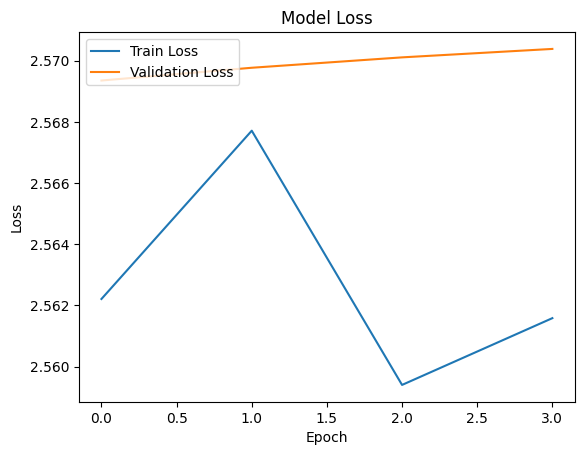

In [25]:
import random
from torch import nn
from tqdm.notebook import tqdm
import numpy as np
import torch
import math
import requests
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

class EasyQAEarlyFusionNetwork(nn.Module):
    def __init__(self, hyperparms=None):
        super(EasyQAEarlyFusionNetwork, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.vision_projection = nn.Linear(2048, 768)
        self.text_projection = nn.Linear(512, 768)
        self.fc1 = nn.Linear(768, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.classifier = nn.Linear(256, 13)
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, image_emb, text_emb):
        x1 = torch.nn.functional.normalize(image_emb, p=2, dim=1)
        Xv = self.relu_f(self.vision_projection(x1))

        x2 = torch.nn.functional.normalize(text_emb, p=2, dim=1)
        Xt = self.relu_f(self.text_projection(x2))

        Xvt = Xv * Xt

        Xvt = torch.matmul(Xvt, self.W.t())
        Xvt = self.relu_f(Xvt)
        Xvt = torch.matmul(Xvt, self.W.t())
        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

model = EasyQAEarlyFusionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals, confidence = [], [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)

        inputs = {'image_emb':  batch[0], 'text_emb': batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)

        labels =  batch[2]
        loss = criterion(outputs.view(-1, 13), labels.view(-1))
        loss_val_total += loss.item()

        probs = torch.max(outputs.softmax(dim=1), dim=-1)[0].detach().cpu().numpy()
        outputs = outputs.argmax(-1)
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        confidence.append(probs)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    confidence = np.concatenate(confidence, axis=0)

    return loss_val_avg, predictions, true_vals, confidence

def accuracy_score_func(preds, labels):
    return np.mean(preds == labels)

def train():
    train_history = open("/content/models/train_history.csv", "w")
    log_hdr = "Epoch, train_loss, train_acc, val_loss, val_acc"
    train_history.write(log_hdr  + "\n")
    train_f1s = []
    val_f1s = []
    train_losses = []
    val_losses = []
    min_val_loss = -1
    max_auc_score = 0
    epochs_no_improve = 0
    early_stopping_epoch = 3
    early_stop = False

    epochs = 10  # Define the number of epochs
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        loss_train_total = 0
        train_predictions, train_true_vals = [], []

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)

            inputs = {'image_emb':  batch[0], 'text_emb': batch[1]}
            labels =  batch[2]

            # Check shapes of the embeddings
            assert inputs['image_emb'].shape[1] == 2048, "image_emb shape mismatch"
            assert inputs['text_emb'].shape[1] == 512, "text_emb shape mismatch"

            outputs = model(**inputs)
            loss = criterion(outputs.view(-1, 13), labels.view(-1))
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            logits = outputs.argmax(-1)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.cpu().numpy()
            train_predictions.append(logits)
            train_true_vals.append(label_ids)

            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        train_predictions = np.concatenate(train_predictions, axis=0)
        train_true_vals = np.concatenate(train_true_vals, axis=0)

        tqdm.write(f'\nEpoch {epoch}')
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
        train_f1 = accuracy_score_func(train_predictions, train_true_vals)
        tqdm.write(f'Train Acc: {train_f1}')

        val_loss, predictions, true_vals, _ = evaluate(dataloader_validation)
        val_f1 = accuracy_score_func(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'Val Acc: {val_f1}')

        if val_f1 >= max_auc_score:
            tqdm.write('\nSaving best model')
            torch.save(model.state_dict(), f'/content/models/easyvqa_finetuned_epoch_{epoch}.model')
            max_auc_score = val_f1

        train_losses.append(loss_train_avg)
        val_losses.append(val_loss)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        log_str = "{}, {}, {}, {}, {}".format(epoch, loss_train_avg, train_f1, val_loss, val_f1)
        train_history.write(log_str + "\n")

        if min_val_loss < 0:
            min_val_loss = val_loss
        else:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_epoch:
                    early_stop = True
                    break
                else:
                    continue

    if early_stop:
        print("Early Stopping activated at epoch -", epoch)
        print("Use the checkpoint at epoch - ", epoch - early_stopping_epoch)

    train_history.close()
    return train_losses, val_losses

# Dummy DataLoader example (replace with actual dataloaders)
image_emb = torch.randn(100, 2048)
text_emb = torch.randn(100, 512)
labels = torch.randint(0, 13, (100,))

dataset = TensorDataset(image_emb, text_emb, labels)
dataloader_train = DataLoader(dataset, batch_size=32, shuffle=True)
dataloader_validation = DataLoader(dataset, batch_size=32, shuffle=False)

# Train the model
try:
    train_losses, val_losses = train()
    torch.cuda.empty_cache()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
except Exception as e:
    print(f"An error occurred: {e}")
